# kNN Algorithm Implementation and Test with Wine Quality Dataset 

Yawen Han

Feb 21, 2018

This Project focuses on implementing a k-Nearest Neighbor (kNN) classification algorithm from scratch and test this method on the Wine_quality Dataset. In this project, a kNN classifier program is written to predict the class of the test records and is evaluated with common evaluation metrics, then is compared with the kNN implementation in Weka. The report is divided into 5 parts: Preliminary Data Analysis, Data Transformation, Model Development, Model Evaluation and Comparison, to describe the program, and its design decisions, evaluations and comparisons with kNN classifier in Weka.

## Preliminary Data Analysis

This section discusses the observed trends with the data before data processing with some statistical analysis and graphs, to help for a better understanding of the dataset and later data processing. The first thing we need to do is loading our data file, and find the correlation between wine quality and other attributes. Since the wine quality will be viewed as a binary class variable according to the rule: if quality<=5, then class="Low"; if quality>5, then class=" High" in later model building. This time, the correlation matrix for quality is generated by adding a numeric binary class with 1 for high quality and -1 for low quality, so a binary attribute named "class" is added according to the rule: if quality<=5, then class=-1; if quality>5, then class=1.

In [1]:
#Loading several helpful packages
%matplotlib inline
import numpy as np
import pandas as pd
import operator
import seaborn as sns
import math
import sklearn
from sklearn import preprocessing
#Loading data
wine = pd.read_csv('/Users/yawenhan/Documents/Python/winequality-red.csv')

In [2]:
# Check the correlation between class and each attibute
wine['class']=wine['quality'].replace(wine[wine['quality']<=5]['quality'],-1)
wine['class']=wine['class'].replace(wine[wine['quality']>5]['quality'],1)
corre=wine.corr()
corre[-1:][:]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
class,0.095093,-0.321441,0.159129,-0.00216,-0.109494,-0.061757,-0.231963,-0.15911,-0.003264,0.218072,0.434751,0.848279,1.0


From the output above, the correlation between "class" and "fixed acidity","residual sugar", "free sulfur dioxide", "pH" is really small, which indicates there is no correlation inside these pairs. Therefore, these four attributes are removed to improve the accuracy of the model. Next editing the binary class "class" according to the rule: if quality<=5, then class="Low"; if quality>5, then class="High". Then the quality attribute is removed after the modification of "class" label.

In [3]:
# Remove attibutes that have no correlation with quality
fa=wine.pop('fixed acidity')
rs=wine.pop('residual sugar')
fsd=wine.pop('free sulfur dioxide')
pH=wine.pop('pH')
#Add a binary class variable with the required rule
wine['class']=wine['quality'].replace(wine[wine['quality']<=5]['quality'],'Low')
wine['class']=wine['class'].replace(wine[wine['quality']>5]['quality'],'High')
#Remove the qulity attibute
qual=wine.pop('quality')
print('Total {} records are provided in the dataset'.format(wine.shape[0]))
print('And the dataset contains {} attributes for red wine quality'.format(wine.shape[1]))

Total 1599 records are provided in the dataset
And the dataset contains 8 attributes for red wine quality


From the output above, this dataset consists of 8 attributes and 1599 records. Out Of these 7 attributes are continuous variables with values. Last(8th) attribute is a categorical variable with values as “Low” or “High” according to the definition rule summarized above. Therefore, this is a binary classification task. Before building the model, the last thing is checking the ratio between two class in given dataset to see if it is reasonable to set the threshold as 0.5. As if most data represents a dominant one class, the predicted class will always tend to be that class if setting the threshold as 0.5.

Total 744 low records are provided in the dataset
Total 855 high records are provided in the dataset


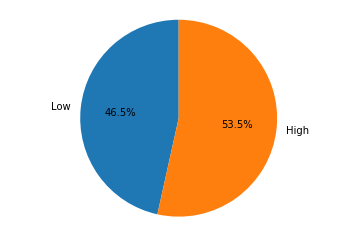

In [4]:
low_count=wine[wine['class']=='Low']['class'].count()
high_count=wine[wine['class']=='High']['class'].count()
print('Total {} low records are provided in the dataset'.format(low_count))
print('Total {} high records are provided in the dataset'.format(high_count))
plt.pie([low_count,high_count], labels=['Low','High'], startangle=90, autopct='%.1f%%')
plt.axis('equal')
plt.figure(figsize=(2,2))
plt.show()

From the above result, the "Low" and "High" classification are 744 and 855 out of 1599 records, with a percentage of 46.5%, 53.5% separately. Since there is no distinct bias on single one class, it sounds reasonable to use 0.5 as a threshold for the following KNN classification.

## Data Transformation

Next we need to split the data into a training dataset that kNN can use to make predictions and a test dataset that we can use to evaluate the accuracy of the model. The participation result should be 75% for the training set and 25% for the test set.

In [19]:
#split dependent variable and independent variable
y=wine['class']
x=wine[['volatile acidity','citric acid','chlorides','total sulfur dioxide','density','sulphates','alcohol']]
#split training set and testing set
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25,random_state = 42)

Since the distance measure is directly dependent on the magnitude of the parameters, the features with higher average values will get more preference whilst decision making. Therefore, it is very important to standardize the dataset first.

In [6]:
#Standardization of dataset
xtrain_scaled = preprocessing.scale(xtrain)#Standardize the training data
scaler = preprocessing.StandardScaler().fit(xtrain)
xtest_scaled = scaler.transform(xtest) #Standardize the test data  
xtrain = pd.DataFrame(xtrain_scaled)
xtest_show = pd.DataFrame(xtest_scaled, columns = ['volatile acidity','citric acid','chlorides','total sulfur dioxide','density','sulphates','alcohol'])
xtest = pd.DataFrame(xtest_scaled)
xtest_show.head()

,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol
0,0.155979,-0.984000,0.517603,-0.023205,0.182158,-0.000095,-0.774740
1,-0.177091,-0.523334,-0.131015,1.673116,-0.415178,-1.027738,-0.869199
2,0.766609,-0.267409,0.375718,-0.386702,1.974168,1.826825,-0.491362
3,-0.399138,0.193257,-0.212093,0.340292,0.670888,-0.685190,-0.585821
4,-0.399138,-0.165039,-0.232362,-0.386702,-1.066818,-0.342643,0.169854


After the partition and standardization of the dataset, the first five rows of test dataset looks like above table. Then the processed data is ready to train and test the model.

## Model Development

### 1) Distance Metric

The k-NN algorithm relies heavily on the idea of similarity of data points. This similarity is computed is using the distance metric. In this case, the Euclidean distance is used as the distance metric, that is, the distance between the points if they were represented in an n-dimensional Cartesian plane.

In [7]:
# Calculate Euclidean Distance
def euclideanDist(x, xi):
 d = 0.0
 for i in range(len(x)):
  d += pow(float(x[i])-float(xi[i]),2)
  d = math.sqrt(d)
 return d

### 2) kNN Implementation

After figuring out the distances between the points, we will use the distances to find the ‘k’ nearest neighbors of the given point and then, based on the classes of these ‘neighbours’, make the prediction on the class of the incoming data. This is quite straight-forward: First calculate the distance between the incoming point and all the points in the training set. Then select a subset of size k from those points and find the probability of the incoming point being in "High" class. If the probability greater than the threshold (0.5), it will be predicted as "High"; otherwise, predicted as "low".

In [8]:
ytrain=list(ytrain)
# Make kNN prediction according to the algorithm
def knn_predict(xtest, xtrain, ytrain, k_value):
    i=0;
    
    test_result=[]#Record prediction results
    posterior_pr=[]#Record posterior probability
    #Predict for each test data
    while i<len(xtest):
        test=xtest[i:i+1]
        i=i+1
        eu_Distance=[]       
        knn = []
        low = 0
        high = 0
        j=0
        #Find the distance between the test data and all training data
        while j<len(xtrain):
            train=xtrain[j:j+1]
            eu_dist = euclideanDist(test, train)
            eu_Distance.append((j, eu_dist))
            j=j+1
        #Sort all distances
        eu_Distance.sort(key = operator.itemgetter(1))
        #Find top k distances
        knn = eu_Distance[:k_value] 
        #Count each class in top k distances
        for k in knn:
            if ytrain[k[0]] =='Low':
                low += 1
            else:
                high +=1     
        #The test data be prodicted as the class with higher probability 
        if low >= high:
            test_result.append('Low') 
        else :
            test_result.append('High')
        posterior_pr.append(float(high)/k_value)  
    #test_se = pd.Series(test_result)
    #post_se = pd.Series(posterior_pr)
    return test_result,posterior_pr
    #xtest['predicted class'] = test_se.values
    #xtest['posterior probability'] = post_se.values

## Model Evaluation

In this section, the model is evaluated for the test dataset with a few different values of k(5,49,99), then confusion matrix and more performance measurements are generated for each k to identify a reasonable value of k. The ROC Curve is plotted at last for the selected k value. In addition, a 400x3 Table is an output for each k with three columns: "actual class", "predicted class", and "posterior probability". The "actual class" is the class of the record that is listed in the test data; "predicted class" is the prediction that is made based on the kNN algorithm and training dataset, and "posterior probability" is the probability that the record belongs to the predicted class, based on the kNN algorithm. In this report, only first 5 results are shown for each k value.

### 1) Prediction Results with k=5

Choosing the value k to be 5 and output a 400x3 Table. (Only first 5 rows shown here)

In [9]:
# Assumed K value
K = 5
# Classify the test data using the kNN model developed above
[test_result,posterior_pr]=knn_predict(xtest, xtrain,ytrain, K)
#ytest_se = pd.Series(list(ytest))
conclusion5=pd.DataFrame(list(ytest))
conclusion5['predicted class']=test_result
conclusion5['posterior probability']=posterior_pr
conclusion5.columns=['actual class','predicted class','posterior probability']
#xtest.columns=['volatile acidity','citric acid','chlorides','total sulfur dioxide','density','sulphates','alcohol','predicted class','posterior probability']
# Output the results
#conclusion5=xtest[['predicted class','posterior probability']]
#ytest_se = pd.Series(list(ytest))
#conclusion5['actual class'] = ytest_se.values
#conclusion5_reorder=conclusion5[['actual class','predicted class','posterior probability']]
conclusion5.head()

,actual class,predicted class,posterior probability
0,High,Low,0.4
1,Low,Low,0.4
2,High,High,0.6
3,Low,High,0.6
4,High,High,0.6


The confusion matrix and more performance measurements for k=5 are shown below.

           pred_high  pred_low
actu_high        124        98
actu_low          79        99


,accuracy,error_rate,TPR,TNR,FPR,FNR,precision,recall,F_measure
0,0.5575,0.4425,0.558559,0.55618,0.44382,0.441441,0.610837,0.558559,0.583529


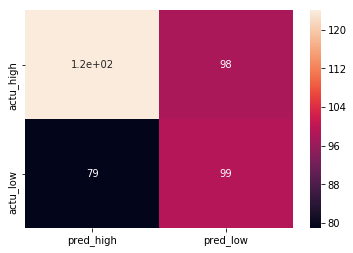

In [10]:
def knn_measure(conclusion_reorder):
    TP=0#Count for True Positive
    FN=0#Count for False Negative
    FP=0#Count for False Positive
    TN=0#Count for True Negative
    #Build Confusion Matrices
    i=0 
    while i<len(conclusion_reorder):
        a=''.join(conclusion_reorder[i:i+1]['predicted class'])
        b=''.join(conclusion_reorder[i:i+1]['actual class']) 
        if (a == 'High') and (b=='High'): 
            TP += 1 
        elif (a=='Low')and(b=='High'):
            FN+=1   
        elif (a=='High')and(b=='Low'):
            FP+=1
        elif (a=='Low')and(b=='Low'):
            TN+=1
        i=i+1
    cm=[[TP,FN],[FP,TN]]#Confusion Matrix  
    df_cm = pd.DataFrame(cm, index = ['actu_high','actu_low'],columns = ['pred_high','pred_low'])
    plt.figure(figsize = (6,4))#Plot the confusion matrix
    sns.heatmap(df_cm, annot=True)
    print(df_cm)
    # Calculate Accuracy and other performance measurements
    accuracy = float(TP+TN)/(TP+TN+FP+FN)#Calculate accuracy 
    error_rate=1-accuracy#Calculate error rate
    TPR=float(TP)/(TP+FN)#Calculate True Positive Rate
    TNR=float(TN)/(TN+FP)#Calculate True Negative Rate
    FPR=float(FP)/(FP+TN)#Calculate False Positive Rate
    FNR=float(FN)/(FN+TP)#Calculate False Negative Rate
    precision=float(TP)/(TP+FP)#Calculate precision
    recall=float(TP)/(TP+FN)#Calculate recall
    F_measure=2*float(TP)/(2*TP+FN+FP)#Calculate F-Measure
    #Use a Table to output the measurements value
    output=[[accuracy,error_rate,TPR,TNR,FPR,FNR,precision,recall,F_measure]]
    out=pd.DataFrame(output,columns = ['accuracy','error_rate','TPR','TNR','FPR','FNR','precision','recall','F_measure'])
    return out 
knn_measure(conclusion5)    

### 2) Prediction Results with k = 99

Choosing the value k to be 99 and output a 400x3 Table. (Only first 5 rows shown here)

In [11]:
# Assumed K value
K = 99
# Classify the test data using the kNN model developed above
[test_result,posterior_pr]=knn_predict(xtest, xtrain,ytrain, K)
#ytest_se = pd.Series(list(ytest))
conclusion99=pd.DataFrame(list(ytest))
conclusion99['predicted class']=test_result
conclusion99['posterior probability']=posterior_pr
conclusion99.columns=['actual class','predicted class','posterior probability']
conclusion99.head()

,actual class,predicted class,posterior probability
0,High,Low,0.434343
1,Low,High,0.565657
2,High,Low,0.333333
3,Low,High,0.555556
4,High,High,0.555556


The confusion matrix and more performance measurements for k=99 are shown below.

           pred_high  pred_low
actu_high        146        76
actu_low          65       113


,accuracy,error_rate,TPR,TNR,FPR,FNR,precision,recall,F_measure
0,0.6475,0.3525,0.657658,0.634831,0.365169,0.342342,0.691943,0.657658,0.674365


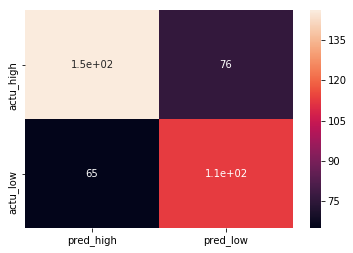

In [12]:
knn_measure(conclusion99)    

### 3) Prediction Results with k = 49

Choosing the value k to be 49 and output a 400x3 Table. (Only first 5 rows shown here)

In [13]:
# Assumed K value
K = 49
# Classify the test data using the kNN model developed above
[test_result,posterior_pr]=knn_predict(xtest, xtrain,ytrain, K)
#ytest_se = pd.Series(list(ytest))
conclusion49=pd.DataFrame(list(ytest))
conclusion49['predicted class']=test_result
conclusion49['posterior probability']=posterior_pr
conclusion49.columns=['actual class','predicted class','posterior probability']
conclusion49.head()

,actual class,predicted class,posterior probability
0,High,Low,0.408163
1,Low,High,0.571429
2,High,Low,0.346939
3,Low,Low,0.489796
4,High,Low,0.489796


The confusion matrix and more performance measurements for k=49 are shown below.

           pred_high  pred_low
actu_high        140        82
actu_low          59       119


,accuracy,error_rate,TPR,TNR,FPR,FNR,precision,recall,F_measure
0,0.6475,0.3525,0.630631,0.668539,0.331461,0.369369,0.703518,0.630631,0.665083


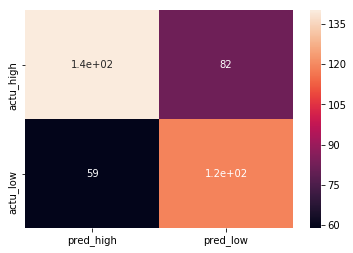

In [14]:
knn_measure(conclusion49)    

From the Confusion Matrix and other performance measurements shown above for three different k values: 5, 49 and 99. It can be easily seen that the model has the same greatest accuracy as 0.6475 when k=49 and k=99, while has a worse accuracy as 0.5575 when k=5. Next, compare the precision of k=49 and k=99: the precision for k=49 is 0.7035 while the precision for k=99 is 0.6919. Since k=49 has a better precision, k=49 is a possibly the best choice among three k values. Therefore, k=5 might cause the "underfitting", making the model too simple; k=99 might cause the "overfitting", making the model too complex.

### 4) ROC Curve for k=49

According to the analysis above, it seems k=49 is the best choice among three k values. Then find out the true positive rate (TPR) and the false positive rate (FPR) at various threshold setting and plot the ROC curves. The table below shows the first 5 rows of the TPR, FPR, and thresholds.

In [15]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
y = list(conclusion49['actual class'])
scores = list(conclusion49['posterior probability'])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label='High')
roc_auc = auc(fpr, tpr)
rc=pd.DataFrame(fpr)
rc['tpr']=list(tpr)
rc['thresholds']=thresholds
rc.columns=['False Positive Rate','True Positive Rate','Thresholds']
rc.head()

,False Positive Rate,True Positive Rate,Thresholds
0,0.000000,0.000000,1.857143
1,0.016854,0.085586,0.857143
2,0.033708,0.238739,0.836735
3,0.056180,0.243243,0.795918
4,0.067416,0.283784,0.775510


In a Receiver Operating Characteristic (ROC) curve the true positive rate (Sensitivity) is plotted in function of the false positive rate for different cut-off points. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. 

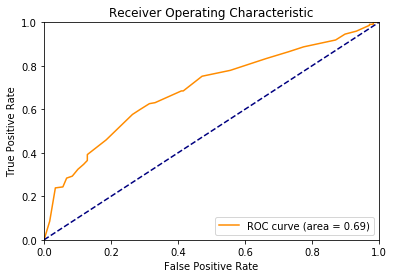

In [16]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In the figure above, the ROC curve is not very close to the upper left corner, which indicates the overall accuracy of the test is not very high. This conclusion can also be made from the area under ROC curve (AUC) as 0.69.

## Comparision

In this section, the kNN classifier implemented above is compared with the kNN classifier in Weka. In Weka, the kNN classifier is named "IBk". Set the "percentage split%" be 75, then start the classification in Weka. The output from Weka is shown below.

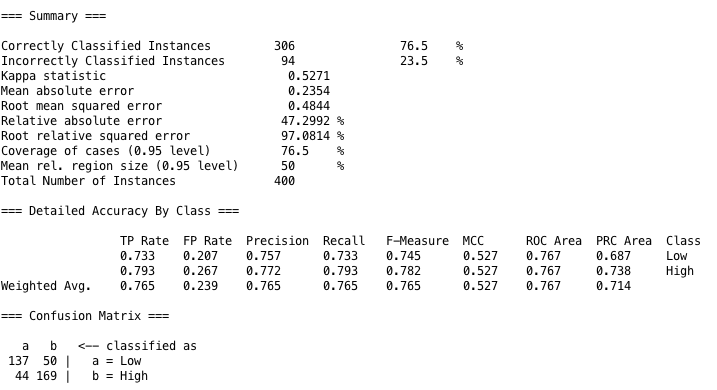

In [17]:
from IPython.display import Image
Image("/Users/yawenhan/Desktop/Weka_output.png")

From the figure above, the kNN model formed by Weka get an accuracy of 76.5%, an average precision of 0.765 and a ROC area of 0.767, which are all better than the accuracy and precision of kNN classifier implemented above. This means the implemented kNN model need more improvements for a better performance. A simple and effective way to remedy skewed class distributions is by implementing weighed voting. The class of each of the K neighbors is multiplied by a weight proportional to the inverse of the distance from that point to the given test point. This ensures that nearer neighbors contribute more to the final vote than the more distant ones. Another option can be changing the distance metric for different applications to help improve the accuracy of the algorithm.

In [21]:
import IPython.core.display as di
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code